In [1]:
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as rn_preprocess
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    precision_score, recall_score, f1_score, accuracy_score
)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
# ======================
# Konfigurasi
# ======================
IMG_SIZE = (224, 224)
BATCH = 32
EPOCHS = 30
ANNOTATION_JSON = "augmented_output/annotations.json"
DATASET_DIR = "dataset_classification"
TRAIN_DIR = os.path.join(DATASET_DIR, "train")
VAL_DIR = os.path.join(DATASET_DIR, "valid")
TEST_DIR = os.path.join(DATASET_DIR, "test")

In [3]:
# ======================
# Load class names
# ======================
class_names = sorted([d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))])
NUM_CLASSES = len(class_names)
class_to_idx = {c: i for i, c in enumerate(class_names)}
print("Detected classes:", class_names)

Detected classes: ['Ganoderma', 'Sehat']


In [5]:
# ======================
# Load data dari annotations.json
# ======================
image_paths, labels_idx = [], []
if os.path.exists(ANNOTATION_JSON):
    with open(ANNOTATION_JSON, "r") as f:
        ann = json.load(f)
    for item in ann:
        cls = item.get("class")
        if cls not in class_to_idx:
            continue
        idx = class_to_idx[cls]
        orig, aug = item.get("original"), item.get("augmented")
        if orig and os.path.exists(orig):
            image_paths.append(orig)
            labels_idx.append(idx)
        if aug and os.path.exists(aug):
            image_paths.append(aug)
            labels_idx.append(idx)
print(f"Total augmented images loaded: {len(image_paths)}")

def preprocess_path_label(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32)
    return img, tf.one_hot(label, NUM_CLASSES)

if len(image_paths) > 0:
    aug_ds = tf.data.Dataset.from_tensor_slices((image_paths, labels_idx))
    aug_ds = aug_ds.shuffle(len(image_paths))
    aug_ds = aug_ds.map(preprocess_path_label, num_parallel_calls=tf.data.AUTOTUNE)
    aug_ds = aug_ds.batch(BATCH).prefetch(tf.data.AUTOTUNE)
else:
    aug_ds = None

Total augmented images loaded: 1974


In [6]:
# ======================
# Load dataset original
# ======================
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR, image_size=IMG_SIZE, batch_size=BATCH,
    label_mode="categorical", shuffle=True
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR, image_size=IMG_SIZE, batch_size=BATCH,
    label_mode="categorical", shuffle=False
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR, image_size=IMG_SIZE, batch_size=BATCH,
    label_mode="categorical", shuffle=False
)

train_ds = train_ds.map(lambda x, y: (tf.cast(x, tf.float32), y))
val_ds = val_ds.map(lambda x, y: (tf.cast(x, tf.float32), y))
test_ds = test_ds.map(lambda x, y: (tf.cast(x, tf.float32), y))

# Gabungkan data
if aug_ds is not None:
    train_ds = train_ds.concatenate(aug_ds).shuffle(1000)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

Found 987 files belonging to 2 classes.
Found 104 files belonging to 2 classes.
Found 42 files belonging to 2 classes.


In [7]:
# ======================
# Augmentasi
# ======================
data_aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
], name="augment")

In [8]:
# ======================
# Model ResNet50
# ======================
base = ResNet50(weights="imagenet", include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base.trainable = False

inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = data_aug(inputs)
x = rn_preprocess(x)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = Model(inputs, outputs)

model.compile(optimizer=Adam(1e-3), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ augment             │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ augment[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ augment[0][0]     │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ augment[0][0]     │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 2048)      │      8,192 │ global_average_p… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        258 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,154,626 (92.14 MB)

 Trainable params: 562,306 (2.15 MB)

 Non-trainable params: 23,592,320 (90.00 MB)

In [9]:
# ======================
# Callbacks
# ======================
cb = [
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint("best_resnet.keras", monitor="val_accuracy", save_best_only=True)
]

In [10]:
# ======================
# Training
# ======================
history_a = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=cb)

# Fine-tuning ResNet50
base.trainable = True
for layer in base.layers:
    if 'conv5' in layer.name or 'conv4' in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

model.compile(optimizer=Adam(5e-5), loss="categorical_crossentropy", metrics=["accuracy"])
history_b = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=cb)

Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 292s 3s/step - accuracy: 0.6143 - loss: 1.3503 - val_accuracy: 0.6635 - val_loss: 1.0278 - learning_rate: 0.0010
Epoch 2/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 288s 3s/step - accuracy: 0.6744 - loss: 1.1613 - val_accuracy: 0.6538 - val_loss: 1.0513 - learning_rate: 0.0010
Epoch 3/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 286s 3s/step - accuracy: 0.7057 - loss: 1.0513 - val_accuracy: 0.7115 - val_loss: 1.0044 - learning_rate: 0.0010
Epoch 4/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 284s 3s/step - accuracy: 0.7035 - loss: 1.0234 - val_accuracy: 0.7115 - val_loss: 0.9744 - learning_rate: 0.0010
Epoch 5/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 298s 3s/step - accuracy: 0.7307 - loss: 0.9604 - val_accuracy: 0.6538 - val_loss: 1.0615 - learning_rate: 0.0010
Epoch 6/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 290s 3s/step - accuracy: 0.7357 - loss: 0.9328 - val_accuracy: 0.6346 - val_loss: 1.0344 - learning_rate: 0.0010
Epoch 7/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 269s 3s/step - accuracy: 0.7362 - loss: 0.9062 - val_acc

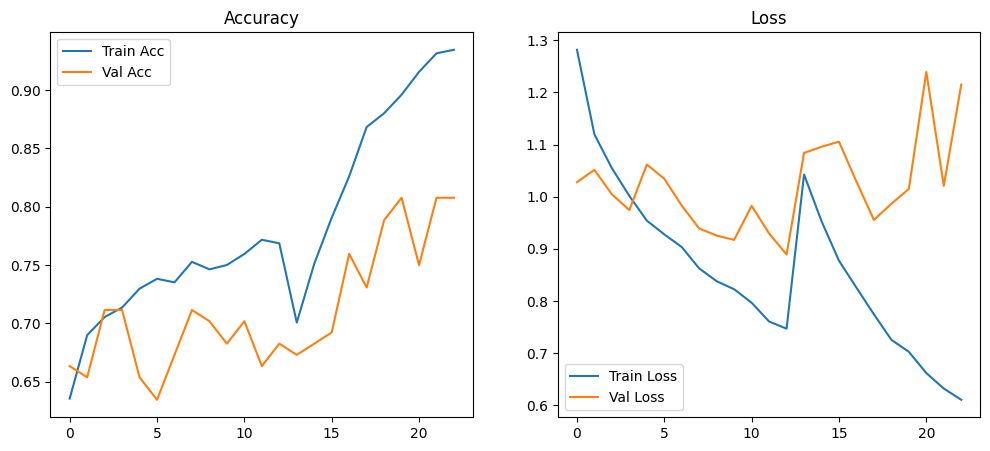

In [11]:
# ======================
# Plot Training Curves
# ======================
def plot_history(histories):
    acc, val_acc, loss, val_loss = [], [], [], []
    for h in histories:
        acc += h.history.get("accuracy", [])
        val_acc += h.history.get("val_accuracy", [])
        loss += h.history.get("loss", [])
        val_loss += h.history.get("val_loss", [])
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(acc, label="Train Acc")
    plt.plot(val_acc, label="Val Acc")
    plt.title("Accuracy")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(loss, label="Train Loss")
    plt.plot(val_loss, label="Val Loss")
    plt.title("Loss")
    plt.legend()
    plt.show()

plot_history([history_a, history_b])

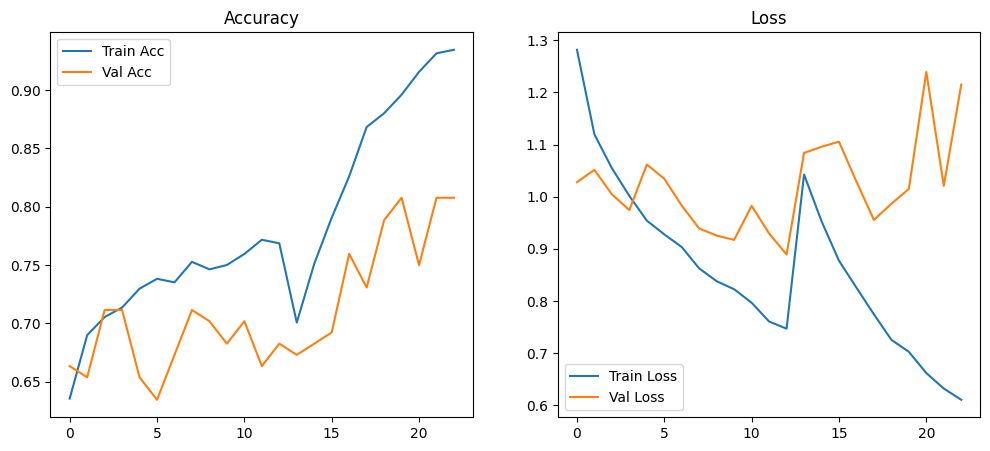

In [12]:
# ======================
# Plot Training Curves
# ======================
def plot_history(histories):
    acc, val_acc, loss, val_loss = [], [], [], []
    for h in histories:
        acc += h.history.get("accuracy", [])
        val_acc += h.history.get("val_accuracy", [])
        loss += h.history.get("loss", [])
        val_loss += h.history.get("val_loss", [])
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(acc, label="Train Acc")
    plt.plot(val_acc, label="Val Acc")
    plt.title("Accuracy")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(loss, label="Train Loss")
    plt.plot(val_loss, label="Val Loss")
    plt.title("Loss")
    plt.legend()
    plt.show()

plot_history([history_a, history_b])